<span style="font-size:25px">Импорт библиотек и настройка окружения</span>

In [2]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt 
%matplotlib inline

C:\Users\User\anaconda33\envs\tf-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU available:", gpus)
else:
    print("No GPU available. Using CPU.")

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

<span style="font-size:25px">Загрузка данных</span>

In [5]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [6]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\User\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=F

<span style="font-size:25px">Предобработка данных</span>

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [9]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [12]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

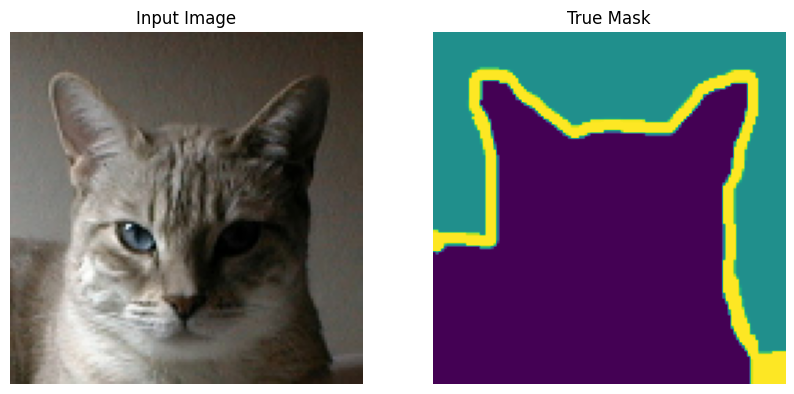

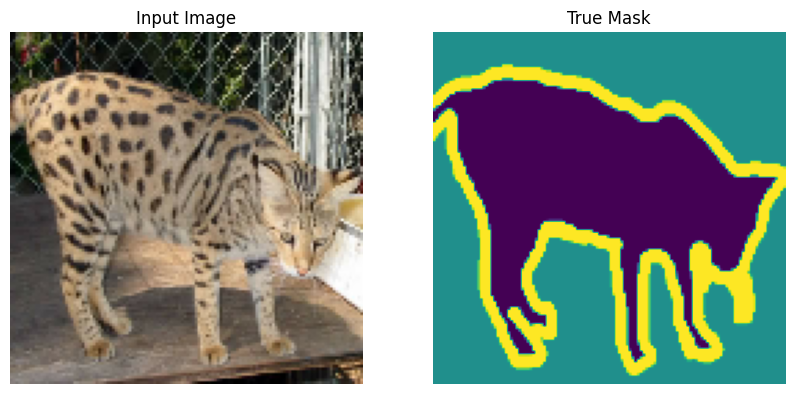

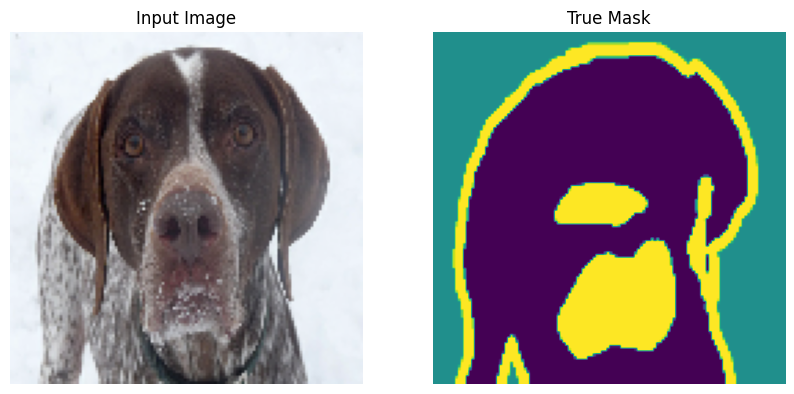

In [13]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

<span style="font-size:25px">Создание модели U-Net</span>

In [14]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [15]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [16]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
     

In [18]:
for image, label in train_dataset.take(1):
    print(image.shape, label.shape)

for image, label in test_dataset.take(1):
    print(image.shape, label.shape)

(64, 128, 128, 3) (64, 128, 128, 1)
(64, 128, 128, 3) (64, 128, 128, 1)


<span style="font-size:25px">Обучение модели и визуализация</span>

In [19]:
EPOCHS = 100
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model_early.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Настроим обучение модели
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]  # Добавляем колбэки
)


Epoch 1/100
57/57 [==============================] - 99s 1s/step - loss: 0.9160 - accuracy: 0.5736 - val_loss: 0.8235 - val_accuracy: 0.5760
Epoch 2/100
57/57 [==============================] - 79s 1s/step - loss: 0.7313 - accuracy: 0.6623 - val_loss: 0.6750 - val_accuracy: 0.7233
Epoch 3/100
57/57 [==============================] - 61s 1s/step - loss: 0.6242 - accuracy: 0.7388 - val_loss: 0.5766 - val_accuracy: 0.7596
Epoch 4/100
57/57 [==============================] - 61s 1s/step - loss: 0.5693 - accuracy: 0.7652 - val_loss: 0.5210 - val_accuracy: 0.7871
Epoch 5/100
57/57 [==============================] - 61s 1s/step - loss: 0.5044 - accuracy: 0.7931 - val_loss: 0.5340 - val_accuracy: 0.7792
Epoch 6/100
57/57 [==============================] - 62s 1s/step - loss: 0.4633 - accuracy: 0.8104 - val_loss: 0.4303 - val_accuracy: 0.8255
Epoch 7/100
57/57 [==============================] - 62s 1s/step - loss: 0.4455 - accuracy: 0.8192 - val_loss: 0.4148 - val_accuracy: 0.8302
Epoch 8/100
5

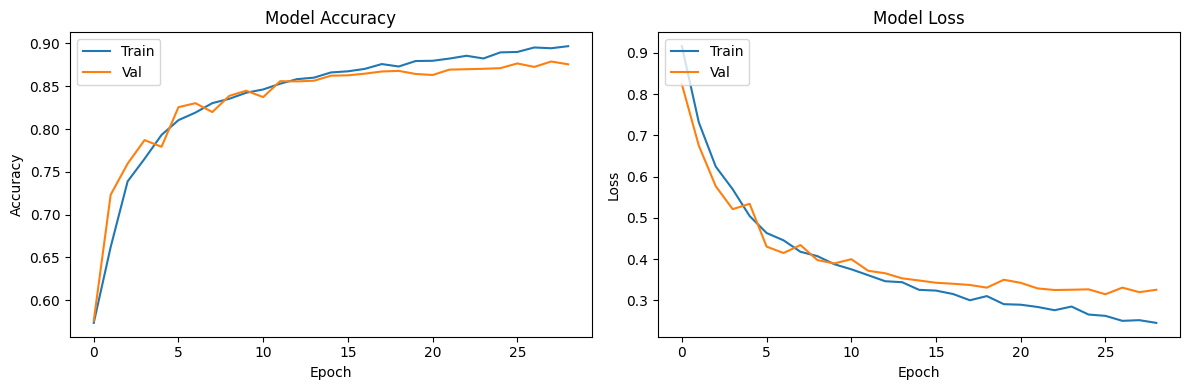

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

2/2 [==============================] - 1s 393ms/step


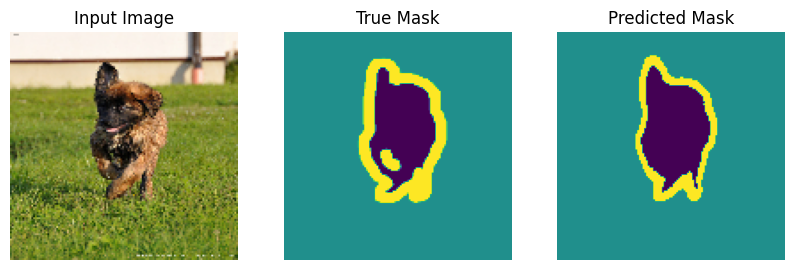

2/2 [==============================] - 0s 118ms/step


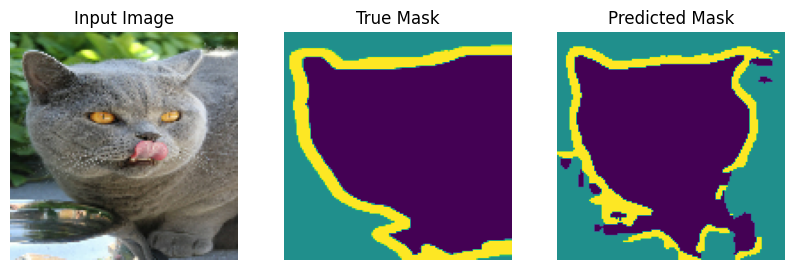

2/2 [==============================] - 0s 113ms/step


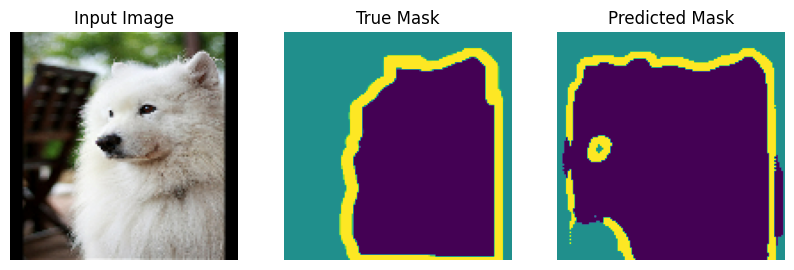

2/2 [==============================] - 0s 107ms/step


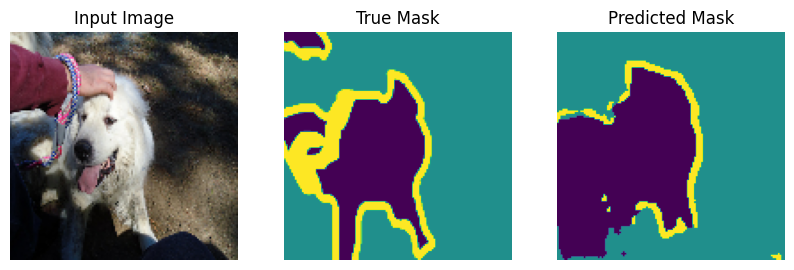

2/2 [==============================] - 0s 107ms/step


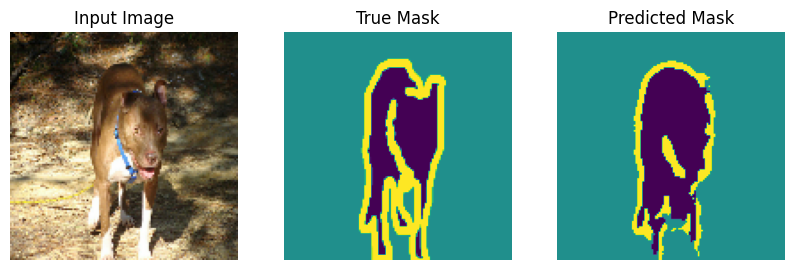

2/2 [==============================] - 0s 107ms/step


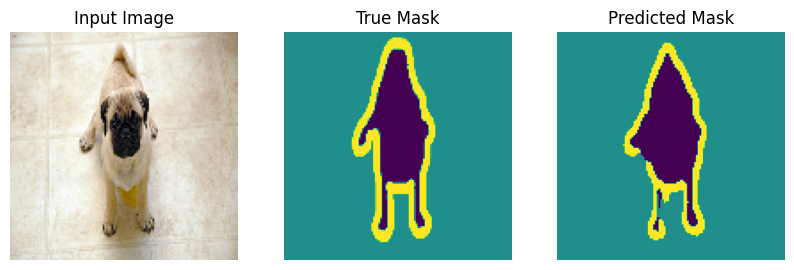

2/2 [==============================] - 0s 108ms/step


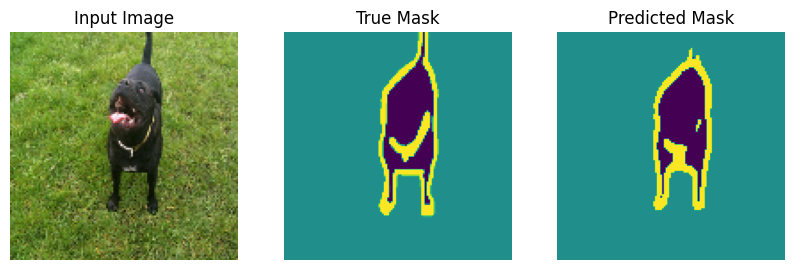

2/2 [==============================] - 0s 105ms/step


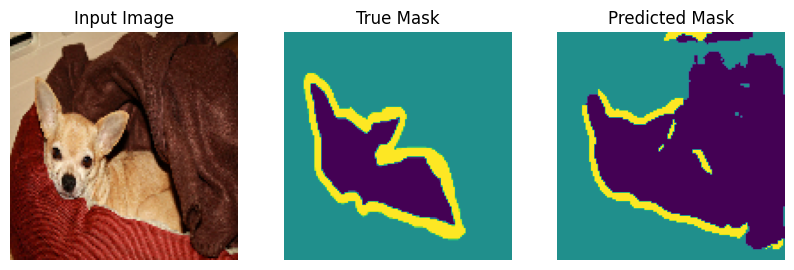

2/2 [==============================] - 0s 108ms/step


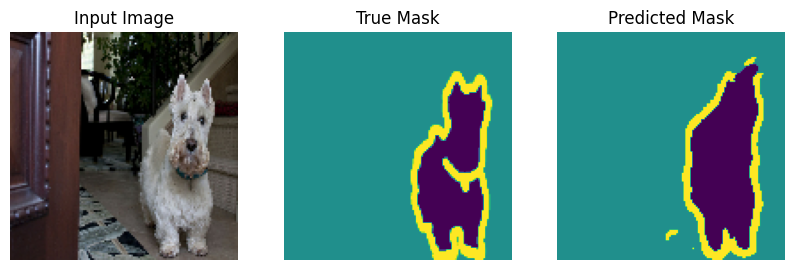

2/2 [==============================] - 0s 107ms/step


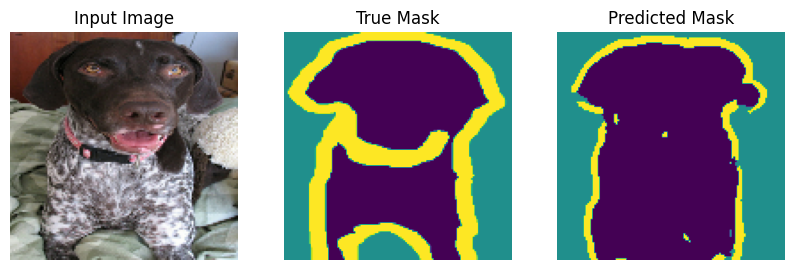

In [22]:
show_predictions(test_dataset, 10)

In [23]:
from tensorflow.keras.models import load_model


# 1. Загрузка обученной модели
model = load_model('best_model_100.h5') #20 эпох

2/2 [==============================] - 1s 363ms/step


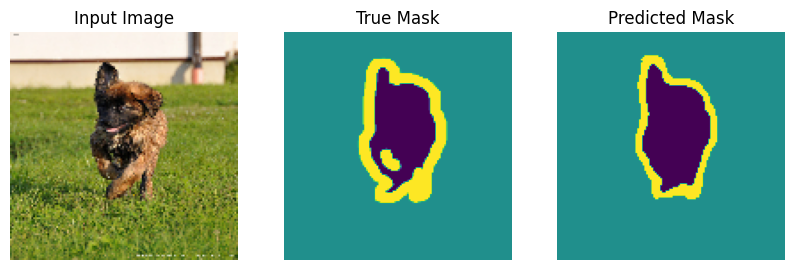

2/2 [==============================] - 0s 108ms/step


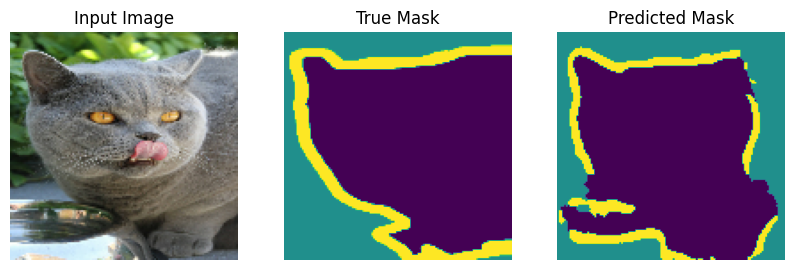

2/2 [==============================] - 0s 109ms/step


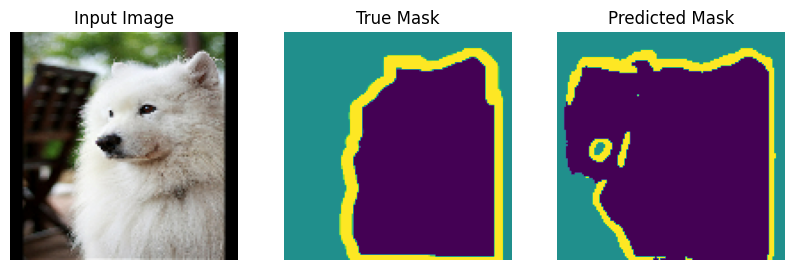

2/2 [==============================] - 0s 104ms/step


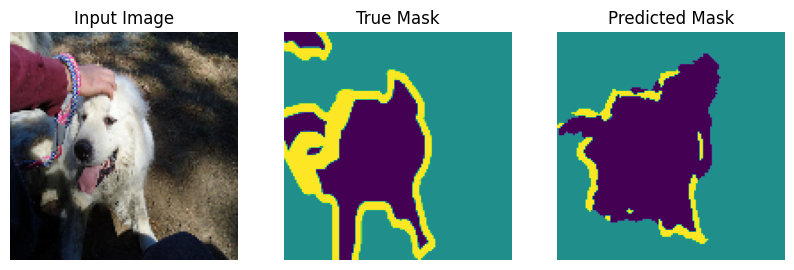

2/2 [==============================] - 0s 101ms/step


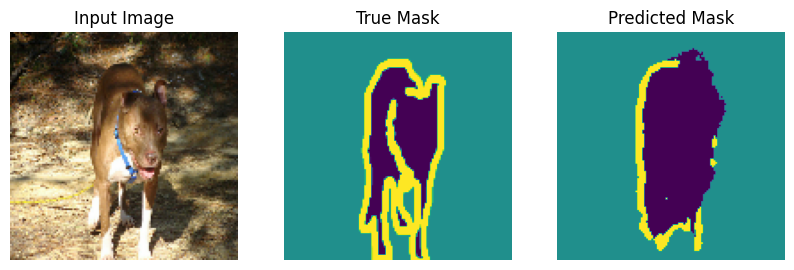

2/2 [==============================] - 0s 105ms/step


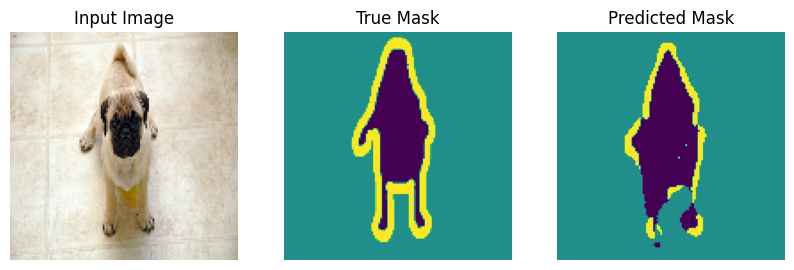

2/2 [==============================] - 0s 107ms/step


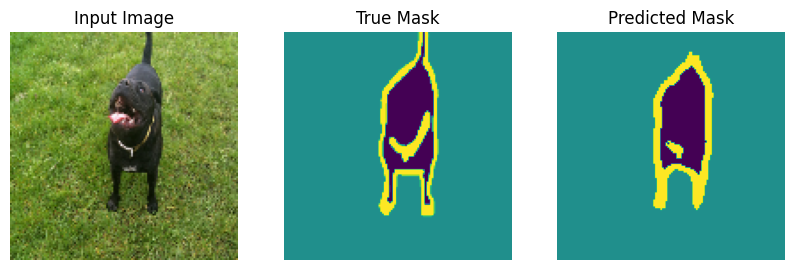

2/2 [==============================] - 0s 107ms/step


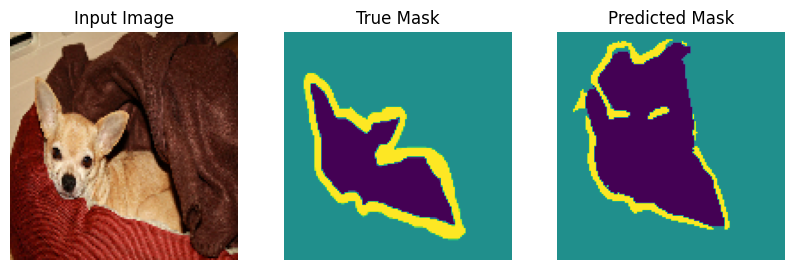

2/2 [==============================] - 0s 112ms/step


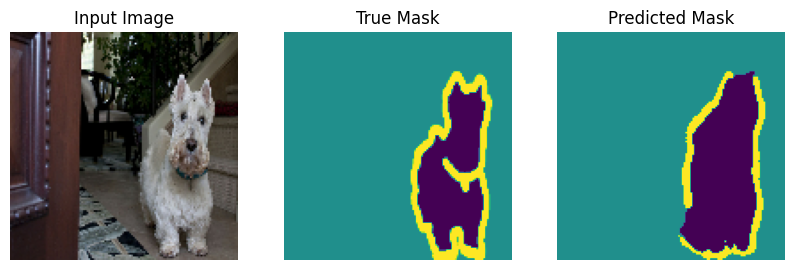

2/2 [==============================] - 0s 107ms/step


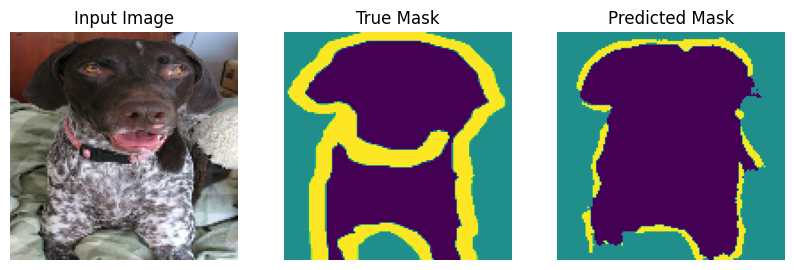

In [24]:
show_predictions(test_dataset, 10)

In [25]:
from tensorflow.keras.models import load_model


# 1. Загрузка обученной модели
model = load_model('best_model.h5') # 7 эпох

2/2 [==============================] - 1s 394ms/step


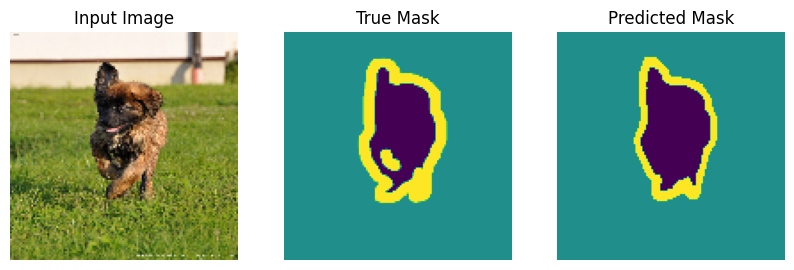

2/2 [==============================] - 0s 108ms/step


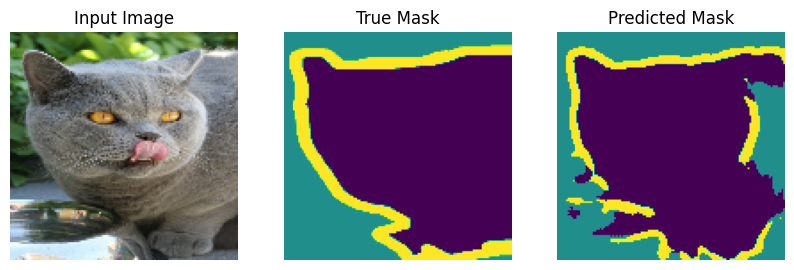

2/2 [==============================] - 0s 107ms/step


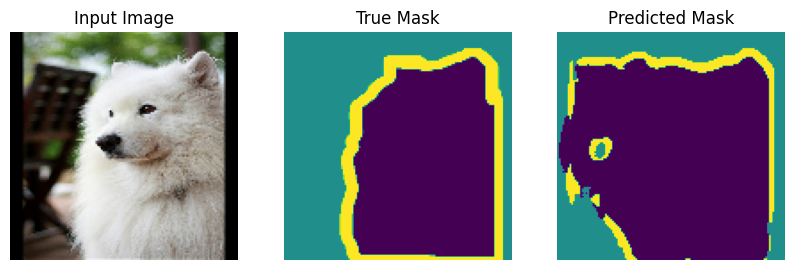

2/2 [==============================] - 0s 95ms/step


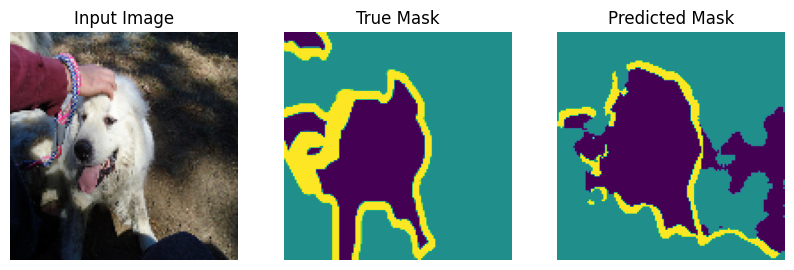

2/2 [==============================] - 0s 106ms/step


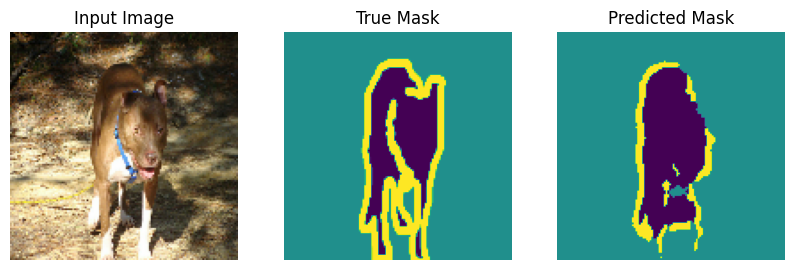

2/2 [==============================] - 0s 107ms/step


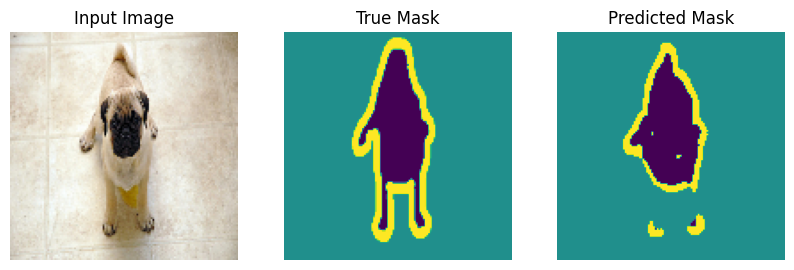

2/2 [==============================] - 0s 107ms/step


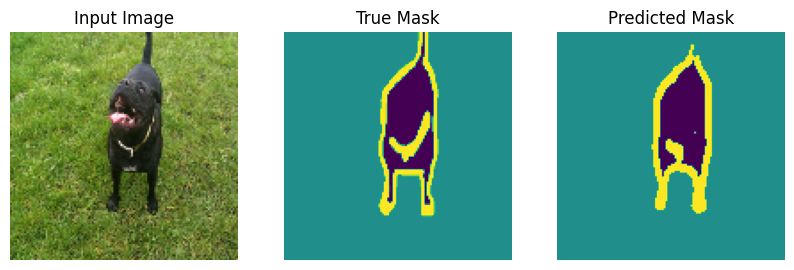

2/2 [==============================] - 0s 107ms/step


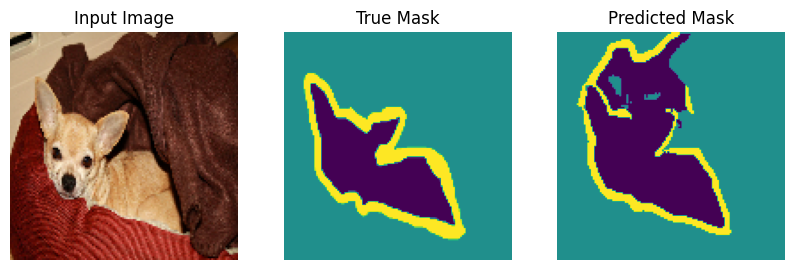

2/2 [==============================] - 0s 108ms/step


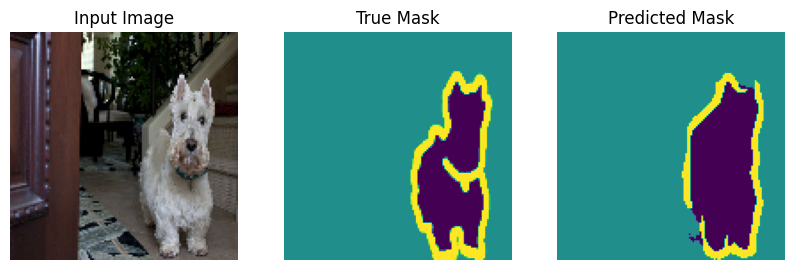

2/2 [==============================] - 0s 105ms/step


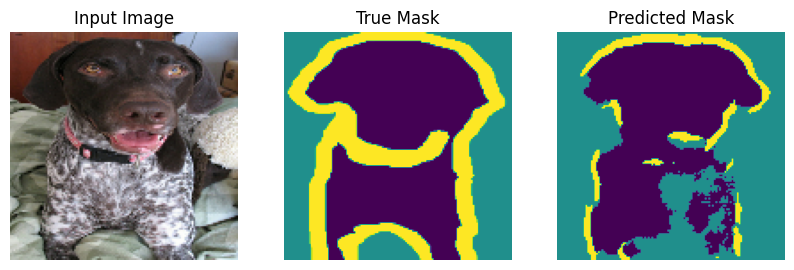

In [26]:
show_predictions(test_dataset, 10)